In [1]:
%load_ext autoreload
%autoreload 2

import warnings
import logging
from tqdm import TqdmWarning
warnings.filterwarnings(module="tqdm.auto", action="ignore", category=TqdmWarning)
warnings.filterwarnings(module="sklearn.feature_extraction.text", action="ignore", category=UserWarning)

from rfc.storage.tfidf import TfidfStorage
from rfc.scrap import scrap
from rfc.index.base import UrlQuery, DocQuery, TextQuery, NameQuery
from rfc.index.tfidf import TfidfIndex
from rfc.index.backends.spacy import SpaCyTfidfVectorizer, download_if_not_exists
from rfc.utils.logging import Logger

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import numpy as np
import pandas as pd

# Request For Comments (RFC)

Authors:
* Vasyl Korzavatykh 158669
* Andrii Chmutov 154974

A **Request for Comments** (RFC) is a publication in a series from the principal technical development and standards-setting bodies for the Internet, most prominently the **Internet Engineering Task Force** (IETF). An RFC is authored by individuals or groups of engineers and computer scientists in the form of a memorandum describing methods, behaviors, research, or innovations applicable to the working of the Internet and Internet-connected systems. It is submitted either for peer review or to convey new concepts, information, or, occasionally, engineering humor.

Our bespoke implementation of search system aims to simplify the process of navigating the website and kick-off the user experience to the next level.

## Configuration

Configure the Project Report with the following parameters:

In [2]:
load_docs = True
load_index = True

db = "data.sqlite"
loglevel = "INFO"
vectorizer_path = "huge.pkl"
nlp_model = "en_core_web_sm"
limit: int = 20
starting_nodes = [
    "https://datatracker.ietf.org/doc/html/rfc791",
]
decay = lambda x: 1.2 ** (-x)

# Download the model if needed
download_if_not_exists(nlp_model)

# Logging verbosity
Logger.setLevel(loglevel)

## Scraping

In our implementation, crawling is performed manually using **following external external links** that match a predefined pattern in **DFS-like** fashion. We opted not to use external library since the results made with our cralwer were satisfactory.

However, we did use dependency for scraping - `inscriptis` performs HTML processing pretty well.

Note: `TfidfStorage` is wrapper for `SQLite` database, that stores both documents and indexer. 

In [3]:
storage = TfidfStorage(db, vectorizer_path)

if not load_docs:
    docs = scrap(starting_nodes, limit, storage=storage, mode="overwrite")
else:
    docs = storage.fetchall()

['https://datatracker.ietf.org/doc/html/rfc791', 'https://datatracker.ietf.org/doc/html/rfc6864', 'https://datatracker.ietf.org/doc/html/rfc1349', 'https://datatracker.ietf.org/doc/html/rfc2474', 'https://datatracker.ietf.org/doc/html/rfc760', 'https://datatracker.ietf.org/doc/html/rfc792', 'https://datatracker.ietf.org/doc/html/rfc796', 'https://datatracker.ietf.org/doc/html/rfc795', 'https://datatracker.ietf.org/doc/html/rfc790', 'https://datatracker.ietf.org/doc/html/rfc1122', 'https://datatracker.ietf.org/doc/html/rfc2003', 'https://datatracker.ietf.org/doc/html/rfc4963', 'https://datatracker.ietf.org/doc/html/rfc5225', 'https://datatracker.ietf.org/doc/html/rfc2119', 'https://datatracker.ietf.org/doc/html/rfc2460', 'https://datatracker.ietf.org/doc/html/rfc4443', 'https://datatracker.ietf.org/doc/html/rfc6621', 'https://datatracker.ietf.org/doc/html/rfc1812', 'https://datatracker.ietf.org/doc/html/rfc6145', 'https://datatracker.ietf.org/doc/html/rfc2671']


## Indexing

In this section, we create **TF-IDF index** based on scraped data.

It is worth noting that we use:
* `en_core_web_sm` for tokenization and **lemmatization**. although you can define bigger model if you want). Punktuation and stopwords defined by `spaCy` are skipped.
* use **another model** (`spaCy` models are installed automatically)
* create a **wrapper** for `TfidfVectorizer` (inheriting from `BaseTfidfVectorizer` from this package) (the model should also be picklabe) that would incorporate **custom backend** (like BERT-based models)


In [4]:
if not load_index:
    tfidf_vectorizer = SpaCyTfidfVectorizer(spacy_model_name=nlp_model)

    index = TfidfIndex.from_docs(docs, tfidf_vectorizer)
    storage.save(index)
else:
    index = storage.load()

root(INFO) - Loading the index (tfidf.py:44)
root(INFO) - Reading tfidf (tfidf.py:167)
root(INFO) - Reading bow (tfidf.py:167)
root(INFO) - Reading idf (tfidf.py:188)


## Scoring

We decided **not** to use some specific tools, like [Qdrant](https://qdrant.tech/) since it might be forbidden. Therefore, we use **Cosine Similarity** for **TF-IDF** vectors as a backbone metric to measure distances betweem vectors.

### Single document / string

In this case, we get a single vector from a document, similarity to which we compute for all other documents in the database. 

In [5]:
temp_docs = index.query("ICMP")

list(map(str, temp_docs))[:5]

root(INFO) - Performing lemmatization (tfidf.py:118)
root(INFO) - Transforming TF-IDF (tfidf.py:121)


['0.262 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc4443", name="RFC 4443 - Internet Control Message Protocol (ICMPv6) for the Internet Protocol Version 6 (IPv6) Specification", text=...)',
 '0.162 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc792", name="RFC 792 - Internet Control Message Protocol", text=...)',
 '0.118 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc2003", name="RFC 2003 - IP Encapsulation within IP", text=...)',
 '0.089 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc1122", name="RFC 1122 - Requirements for Internet Hosts - Communication Layers", text=...)',
 '0.088 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc1349", name="RFC 1349 - Type of Service in the Internet Protocol Suite", text=...)']

We can see that ICMP article pops up as the most relevant, which is a desired behavior.

### Multiple documents

When querying by history, we perform the same operation as we did in case for a single document, but then we **aggregate** results by **weighted average**, with weight defined by the decay function.


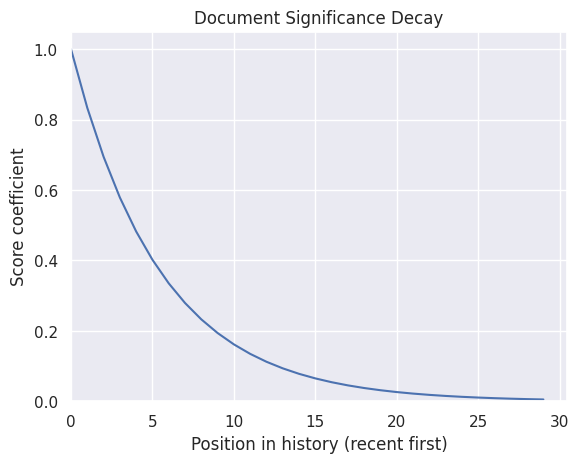

In [6]:
# History with 30 documents
x = np.arange(0, 30)
y = decay(x)

plt.plot(x, y)
plt.title("Document Significance Decay")
plt.xlabel("Position in history (recent first)")
plt.ylabel("Score coefficient")
plt.xlim(0)
plt.ylim(0);

Here we use exponential decay.

## Interesting statistics

#### General stats

In [7]:
print("Number of documents", len(docs))
print("Average number of tokens", (index.bow).sum(1).mean())
print("Average number of words", sum([len(doc.text.split()) for doc in docs]) / len(docs))

Number of documents 20
Average number of tokens 6593.25
Average number of words 11693.3


#### Most frequent words

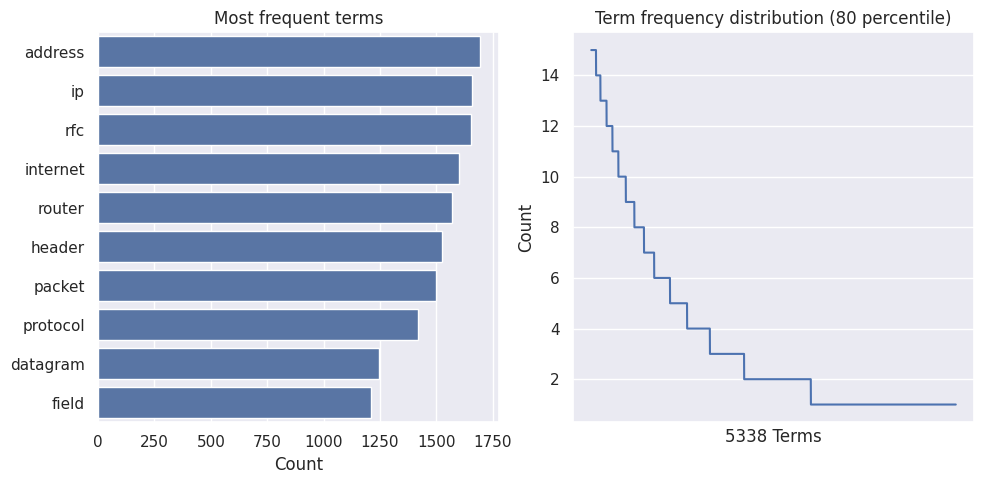

In [8]:
limit_output = 10

_, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].set_title("Most frequent terms")
axes[0].set_xlabel("Count")
sns.barplot(index.bow.sum().sort_values()[::-1][:limit_output], orient="h", ax=axes[0]);

term_frequencies = index.bow.sum().sort_values(ascending=False)
percentile_n = 80
percentile = np.percentile(term_frequencies, percentile_n)
term_frequencies = term_frequencies[term_frequencies <= percentile]

axes[1].set_title(f"Term frequency distribution ({percentile_n} percentile)")
axes[1].set_xlabel(f"{len(term_frequencies)} Terms")
axes[1].set_ylabel("Count")
axes[1].set_xticks([])

sns.lineplot(term_frequencies, ax=axes[1])
plt.tight_layout()

#### Most important words

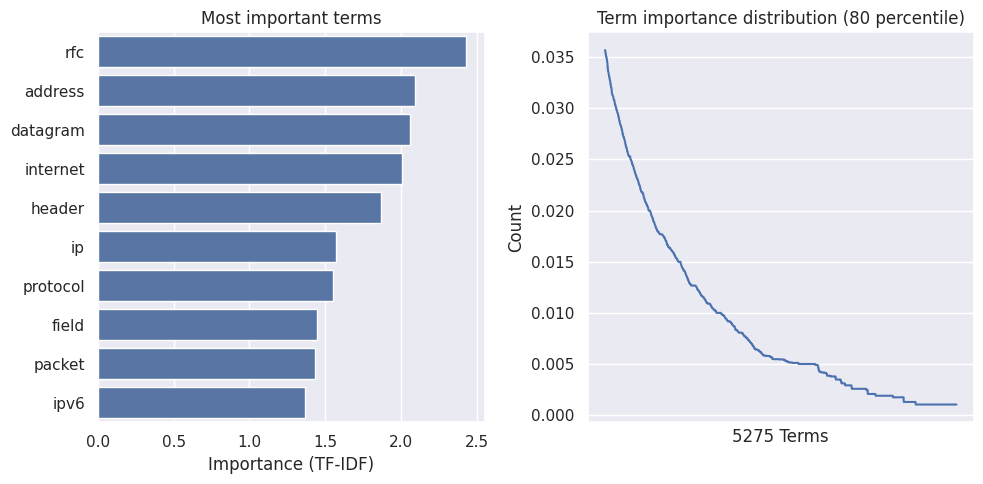

In [9]:
limit_output = 10

_, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].set_title("Most important terms")
axes[0].set_xlabel("Importance (TF-IDF)")
sns.barplot(index.tfidf.sum().sort_values()[::-1][:limit_output], orient="h", ax=axes[0]);

term_frequencies = index.tfidf.sum().sort_values(ascending=False)
percentile_n = 80
percentile = np.percentile(term_frequencies, percentile_n)
term_frequencies = term_frequencies[term_frequencies <= percentile]

axes[1].set_title(f"Term importance distribution ({percentile_n} percentile)")
axes[1].set_xlabel(f"{len(term_frequencies)} Terms")
axes[1].set_ylabel("Count")
axes[1].set_xticks([])

sns.lineplot(term_frequencies, ax=axes[1])
plt.tight_layout()

Even though the data is aggregated and the IDF is now effectively vanished, still the logarithm introduces changes compared to frequency

Again, it is a bit different compared to frequency - it is more gradual.

#### Document similarity

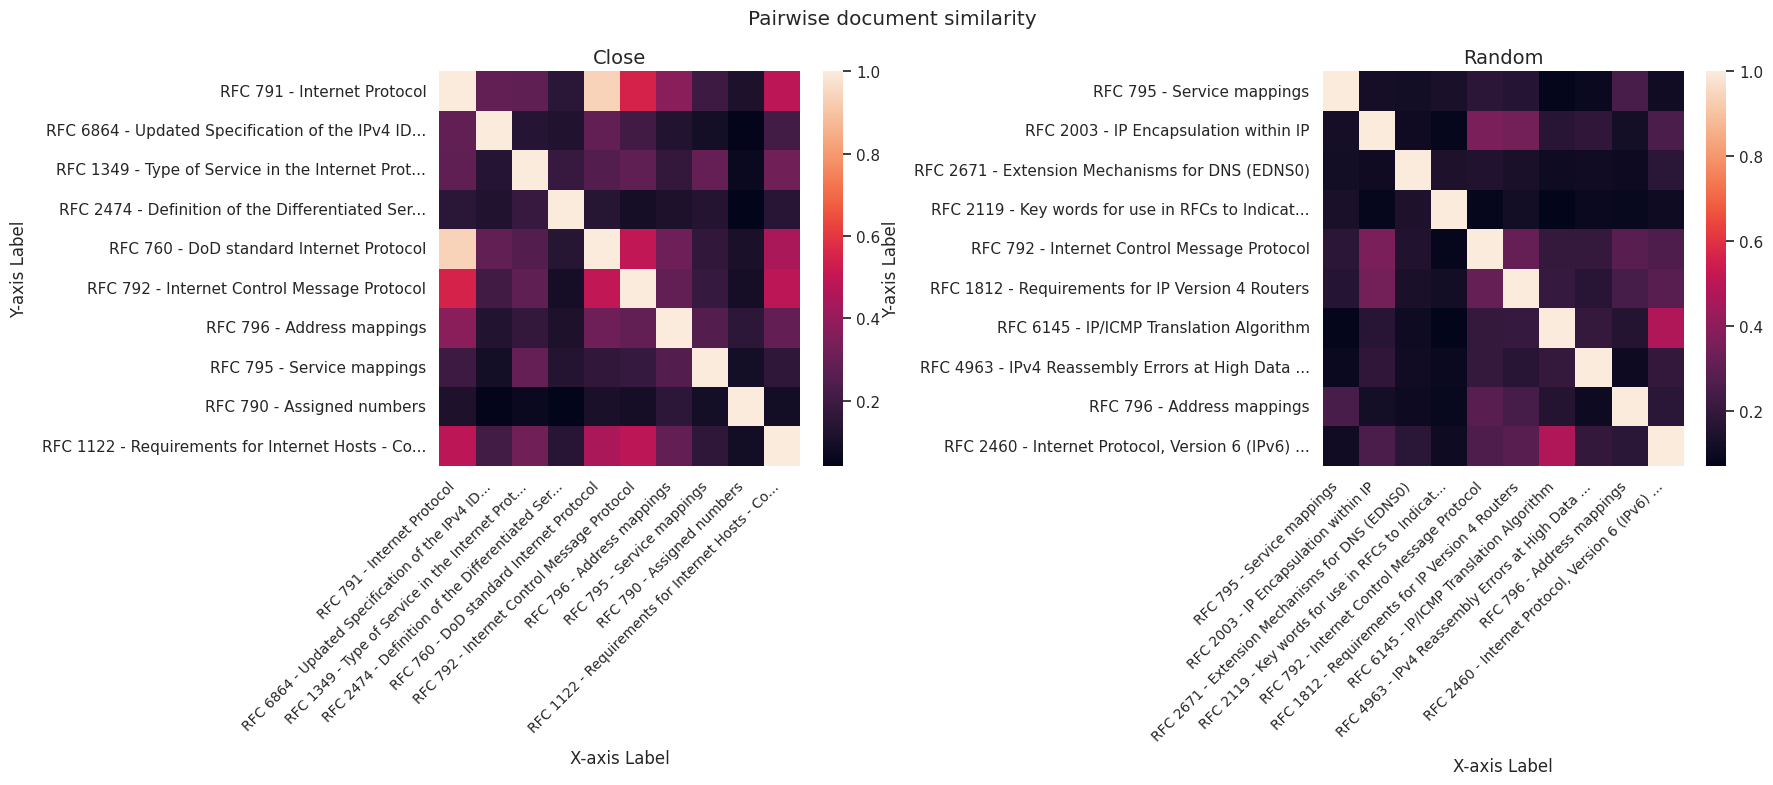

In [10]:
limit_output = 10

# Get random indices
np.random.seed(21)
random_indices = np.arange(len(docs))
np.random.shuffle(random_indices)
random_indices = random_indices[:limit_output]

selected_indices = [
    (np.arange(limit_output), "Close"),
    (random_indices, "Random"),
]

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle("Pairwise document similarity")

for i, (indices, label) in enumerate(selected_indices):
    selected_docs = [docs[i] for i in indices]
    names = []
    scores = []
    for doc in selected_docs:
        if len(doc.name) > 50:
            name = doc.name[:47] + "..."
            names.append(name)
        else:
            names.append(doc.name)
        
        ranked = index.query_docs([DocQuery(doc)], sort=False)
        scores.append([ranked[i].rank for i in indices])
    scores = np.array(scores)
    
    sns.heatmap(scores, yticklabels=names, ax=axes[i])
    axes[i].set_title(label, fontsize=14)
    axes[i].set_xlabel('X-axis Label', fontsize=12, labelpad=10)
    axes[i].set_ylabel('Y-axis Label', fontsize=12, labelpad=10)
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)
    axes[i].set_xticklabels(names, ha="right")
plt.tight_layout()

Since documents were stored in the order they were scraped (i.e. DFS), adjacent documents are likely to have more in common than those that were drawn randomly. 

## Examples

### Using different sources

In [15]:
limit_output = 5
query = [
    NameQuery("Assigned numbers"),
    UrlQuery("https://en.wikipedia.org/wiki/Internet_Control_Message_Protocol"),
    TextQuery("ICMP"),
]

Logger.setLevel("WARNING")
print("Without skipping")
print(("\n".join(map(str, index.query_docs(query, decay=decay)[:limit_output]))))
print()
print("With skipping")
print(("\n".join(map(str, index.query_docs(query, decay=decay, skip_visited=True)[:limit_output]))))
Logger.setLevel("INFO")

Without skipping
0.178 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc791", name="RFC 791 - Internet Protocol", text=...)
0.118 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc792", name="RFC 792 - Internet Control Message Protocol", text=...)
0.111 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc1349", name="RFC 1349 - Type of Service in the Internet Protocol Suite", text=...)
0.085 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc790", name="RFC 790 - Assigned numbers", text=...)
0.076 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc760", name="RFC 760 - DoD standard Internet Protocol", text=...)

With skipping
0.178 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc791", name="RFC 791 - Internet Protocol", text=...)
0.118 RankedDocument(url="https://datatracker.ietf.org/doc/html/rfc792", name="RFC 792 - Internet Control Message Protocol", text=...)
0.111 RankedDocument(url="https://datatracker.ietf.org/doc/h

### Contribution of top terms

### Counterfactual explanation